In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from tqdm import tqdm
from pymongo import MongoClient
from packaging.version import Version
%matplotlib inline
%config InlineBackend.figure_format = "svg"
print(pd.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.3.4
0.11.2
3.5.0


## Load Data

In [2]:
ms_df = pd.read_csv('data/mindspore.csv')
ms_df['framework'] = 'mindspore'
ms_df['dependent_number'] = ms_df['dependent_number'].fillna(0).astype(int)
pp_df = pd.read_csv('data/paddlepaddle.csv')
pp_df['framework'] = 'paddlepaddle'
pp_df['dependent_number'] = pp_df['dependent_number'].fillna(0).astype(int)
torch_df = pd.read_csv('data/torch.csv')
torch_df['framework'] = 'pytorch'
torch_df['dependent_number'] = torch_df['dependent_number'].fillna(0).astype(int)
tf_df = pd.read_csv('data/tensorflow.csv')
tf_df['framework'] = 'tensorflow'
tf_df['dependent_number'] = tf_df['dependent_number'].fillna(0).astype(int)
all_df = pd.concat([ms_df, pp_df, torch_df, tf_df], ignore_index=True)
print('Toal number of packages in each SC:')
print(len(ms_df), len(pp_df), len(torch_df), len(tf_df), len(all_df))

ms_packages = set(ms_df['name'].unique())
pp_packages = set(pp_df['name'].unique())
torch_packages = set(torch_df['name'].unique())
tf_packages = set(tf_df['name'].unique())
all_packages = set(all_df['name'].unique())
print('Total number of unique packages in each SC:')
print(len(ms_packages), len(pp_packages), len(
    torch_packages), len(tf_packages), len(all_packages))

Toal number of packages in each SC:
13 121 5926 5622 11682
Total number of unique packages in each SC:
13 82 3494 3602 6251


## Package Types

### Sample
- For PyTorch and TensorFlow SC, I randomly select 10% packages of layer 2-5 respectively and select all packages in layer6.
- For MindSpore and PaddlePaddle, I select all packages.
- The sample statistics are below:
|              | Layer 2 | Layer 3 | Layer 4 | Layer 5 | Layer 6 | Total |
|--------------|---------|---------|---------|---------|---------|-------|
| TensorFlow   | 234     | 159     | 46      | 14      | 12      | 465   |
| PyTorch      | 287     | 190     | 12      | 2       | 2       | 493   |
| PaddlePaddle | 71      | 20      | 2       | 0       | 0       | 93    |
| MindSpore    | 10      | 0       | 0       | 0       | 0       | 10    |
| Total        | 602     | 369     | 60      | 16      | 14      | 1061  |

In [3]:
# Here I remove packages without summary and urls
ms_df_with_summary_url = ms_df[(pd.notna(ms_df['summary'])) | (pd.notna(ms_df['home_page'])) | (pd.notna(ms_df['download_url'])) | 
                               (ms_df['project_urls'].str.len() > 2)][['name', 'layer', 'framework']].drop_duplicates()
pp_df_with_summary_url = pp_df[(pd.notna(pp_df['summary'])) | (pd.notna(pp_df['home_page'])) | (pd.notna(pp_df['download_url'])) | 
                               (pp_df['project_urls'].str.len() > 2)][['name', 'layer', 'framework']].drop_duplicates()
torch_df_with_summary_url = torch_df[(pd.notna(torch_df['summary'])) | (pd.notna(torch_df['home_page'])) | 
                                     (pd.notna(torch_df['download_url'])) | (torch_df['project_urls'].str.len() > 2)][['name', 'layer', 'framework']].drop_duplicates()
tf_df_with_summary_url = tf_df[(pd.notna(tf_df['summary'])) | (pd.notna(tf_df['home_page'])) | (pd.notna(tf_df['download_url'])) | 
                               (tf_df['project_urls'].str.len() > 2)][['name', 'layer', 'framework']].drop_duplicates()
pd.concat([ms_df_with_summary_url, pp_df_with_summary_url, torch_df_with_summary_url, 
           tf_df_with_summary_url]).groupby(['layer']).size()

layer
1      19
2    5284
3    3511
4     588
5     152
6      14
dtype: int64

In [4]:
len(torch_df_with_summary_url[torch_df_with_summary_url.layer == 2]), len(tf_df_with_summary_url[tf_df_with_summary_url.layer == 2])

(2867, 2336)

In [5]:
samples = pd.DataFrame()
samples = samples.append([pd.concat([torch_df_with_summary_url[torch_df_with_summary_url['layer'] == i].sample(frac=0.1, random_state=1),
                          tf_df_with_summary_url[tf_df_with_summary_url['layer'] == i].sample(frac=0.1, random_state=1)], ignore_index=True)
               for i in range(2, 6)], ignore_index=True)
samples = samples.append([ms_df_with_summary_url[ms_df_with_summary_url['layer'] > 1], 
                         pp_df_with_summary_url[pp_df_with_summary_url['layer'] > 1]] )
samples = samples.append([torch_df_with_summary_url[torch_df_with_summary_url['layer'] == 6],
                        tf_df_with_summary_url[tf_df_with_summary_url['layer'] == 6]])
print('Total samples:', len(samples))
print('tensorflow samples:', len(samples[samples['framework'] == 'tensorflow'])) 
print('pytorch samples:', len(samples[samples['framework'] == 'pytorch']))
print('paddlepaddle samples:', len(samples[samples['framework'] == 'paddlepaddle']))
print('mindspore samples:', len(samples[samples['framework'] == 'mindspore']))
print(samples.groupby(['framework', 'layer']).size().unstack().fillna(0).astype(int))
samples.to_excel('data/samples.xlsx', index=False)
## 2 packages in PaddlePaddle SC layer 3 are paddlepaddle and paddlepaddle-gpu, so I manually drop them

Total samples: 1063
tensorflow samples: 465
pytorch samples: 493
paddlepaddle samples: 95
mindspore samples: 10
layer           2    3   4   5   6
framework                         
mindspore      10    0   0   0   0
paddlepaddle   71   22   2   0   0
pytorch       287  190  12   2   2
tensorflow    234  159  46  14  12


In [6]:
labelled_packages = pd.read_excel('data/labelled_samples.xlsx')
labelled_packages.head()

,name,summary,home_page,project_urls,download_url,layer,dependent_number,dependency,framework,DR/NDR,Category,Subcategory,Comment
0,cogdl,An Extensive Research Toolkit for Deep Learnin...,https://github.com/THUDM/cogdl,[],NaN,2,1,torch,pytorch,DR,Other,NaN,Graph
1,pau,Pade Activation Unit,https://github.com/alejandromolinaml/SPFlow,[],NaN,2,0,torch,pytorch,NDR,Model,NaN,NaN
2,ai-core,Allows you to focus on building applications u...,https://github.com/AI-Core/ai-core,[],NaN,2,0,torch,pytorch,NDR,Framework,NaN,NaN
3,circFL-deep,circFL-deep: a tool for full-length circRNA is...,https://github.com/yangence/circFL-deep,[],NaN,2,0,torch,pytorch,DR,Biology,NaN,404
4,fonduer,Knowledge base construction system for richly ...,https://github.com/HazyResearch/fonduer,"['Tracker, https://github.com/HazyResearch/fon...",NaN,2,0,torch,pytorch,DR,NLP,NaN,NaN


In [7]:
def overall_layer(layer: int):
    print("Layer {}:".format(layer))
    dr, ndr, Unknown = 0, 0, 0
    
    df1 = labelled_packages[labelled_packages['layer'] == layer]
    ptc = len(torch_df_with_summary_url[torch_df_with_summary_url['layer'] == layer])
    tf = len(tf_df_with_summary_url[tf_df_with_summary_url['layer'] == layer])
    ms = len(ms_df_with_summary_url[ms_df_with_summary_url['layer'] == layer])
    pp = len(pp_df_with_summary_url[pp_df_with_summary_url['layer'] == layer])
    print("PyTorch: {}, TensorFlow: {}, MindSpore: {}, PaddlePaddle: {}".format(ptc, tf, ms, pp))
    
    dr += int(len(df1[(df1['framework'] == 'pytorch') & (df1['DR/NDR'] == 'DR')]) / len(df1[(df1['framework'] == 'pytorch')]) * ptc)
    ndr += int(len(df1[(df1['framework'] == 'pytorch') & (df1['DR/NDR'] == 'NDR')]) / len(df1[(df1['framework'] == 'pytorch')]) * ptc)
    Unknown += int(len(df1[(df1['framework'] == 'pytorch') & (df1['DR/NDR'] == '\\')]) / len(df1[(df1['framework'] == 'pytorch')]) * ptc)
    dr += int(len(df1[(df1['framework'] == 'tensorflow') & (df1['DR/NDR'] == 'DR')]) / len(df1[(df1['framework'] == 'tensorflow')]) * tf)
    ndr += int(len(df1[(df1['framework'] == 'tensorflow') & (df1['DR/NDR'] == 'NDR')]) / len(df1[(df1['framework'] == 'tensorflow')]) * tf)
    Unknown += int(len(df1[(df1['framework'] == 'tensorflow') & (df1['DR/NDR'] == '\\')]) / len(df1[(df1['framework'] == 'tensorflow')]) * tf)
    dr += len(df1[(df1['framework'] == 'paddlepaddle') & (df1['DR/NDR'] == 'DR')])
    ndr += len(df1[(df1['framework'] == 'paddlepaddle') & (df1['DR/NDR'] == 'NDR')])
    Unknown += len(df1[(df1['framework'] == 'paddlepaddle') & (df1['DR/NDR'] == '\\')])
    dr += len(df1[(df1['framework'] == 'mindspore') & (df1['DR/NDR'] == 'DR')])
    ndr += len(df1[(df1['framework'] == 'mindspore') & (df1['DR/NDR'] == 'NDR')])
    Unknown += len(df1[(df1['framework'] == 'mindspore') & (df1['DR/NDR'] == '\\')])
    print("DR: {}, NDR: {}, Unknown: {}".format(dr, ndr, Unknown))
    s = dr + ndr + Unknown
    print("DR: {:.1f}, NDR: {:.1f},Unknown: {:.1f}".format(100 *dr / s, 100 * ndr / s, 100 * Unknown / s))

In [8]:
overall_layer(2)
overall_layer(3)
overall_layer(4)
overall_layer(5)
overall_layer(6)

Layer 2:
PyTorch: 2867, TensorFlow: 2336, MindSpore: 10, PaddlePaddle: 71
DR: 2960, NDR: 1695, Unknown: 626
DR: 56.0, NDR: 32.1,Unknown: 11.9
Layer 3:
PyTorch: 1901, TensorFlow: 1588, MindSpore: 0, PaddlePaddle: 22
DR: 2070, NDR: 964, Unknown: 472
DR: 59.0, NDR: 27.5,Unknown: 13.5
Layer 4:
PyTorch: 121, TensorFlow: 465, MindSpore: 0, PaddlePaddle: 2
DR: 374, NDR: 141, Unknown: 71
DR: 63.8, NDR: 24.1,Unknown: 12.1
Layer 5:
PyTorch: 16, TensorFlow: 136, MindSpore: 0, PaddlePaddle: 0
DR: 132, NDR: 9, Unknown: 9
DR: 88.0, NDR: 6.0,Unknown: 6.0
Layer 6:
PyTorch: 2, TensorFlow: 12, MindSpore: 0, PaddlePaddle: 0
DR: 6, NDR: 4, Unknown: 4
DR: 42.9, NDR: 28.6,Unknown: 28.6


### Overall Package Types   
DR: Domain Related, NDR: Non Domain Related
- Overall, the ratio of DR packages increases over layer (from 56.0% to 88.0%) and that of NDR packages decreases over layer (from 32.1% to 6.0%), which is inline with our general understanding that packages in the SC downstream are more and more specific.
- The outlier is in layer 6 where NDR packages occupies 28.6%, which is because of the azureml tools.
- Each layer, there are considerable packages that can not be labelled properly, some packages don't specify their repos and some don't have detail summary, and some packages are removed from PyPI.

{'Layer2': [56.0, 32.1, 11.9], 'Layer3': [59.0, 27.5, 13.5], 'Layer4': [63.8, 24.1, 12.1], 'Layer5': [88.0, 6.0, 6.0], 'Layer6': [42.8, 28.6, 28.6]}


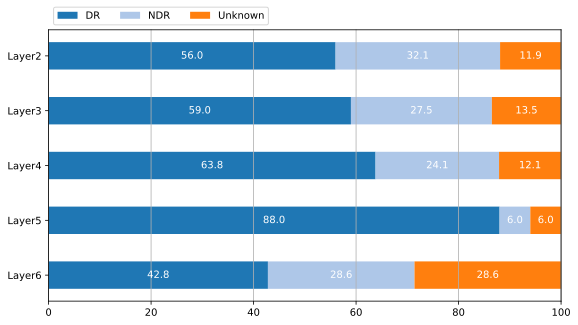

In [9]:
import numpy as np
results = {"Layer2": [56.0, 32.1, 11.9],
         "Layer3": [59.0, 27.5, 13.5],
         "Layer4": [63.8, 24.1, 12.1],
         "Layer5": [88.0, 6.0, 6.0],
         "Layer6": [42.8, 28.6, 28.6]}
category_names = ['DR', 'NDR', 'Unknown']
print(results)
def horizon_bar(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('tab20')(list(range(0, data.shape[1])))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(True)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    ax.grid(True, axis='x')

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(c), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left')

    return fig, ax


fig, _ = horizon_bar(results, category_names)
fig.savefig('figures/dr_ndr.pdf', bbox_inches='tight')
plt.show()

### Overall Packages Categories

In [10]:
def overall_category(layer: int):
    print("Layer {}:".format(layer))
    df1 = labelled_packages[labelled_packages['layer'] == layer]
    dr_categories = df1[df1['DR/NDR'] == 'DR']['Category'].unique()
    ndr_categories = df1[df1['DR/NDR'] == 'NDR']['Category'].unique()
    dr_res = {}
    ndr_res = {}
    for c in dr_categories:
        dr_res[c] = 0
    for c in ndr_categories:
        ndr_res[c] = 0
    
    ptc = len(torch_df_with_summary_url[torch_df_with_summary_url['layer'] == layer])
    tf = len(tf_df_with_summary_url[tf_df_with_summary_url['layer'] == layer])
    ms = len(ms_df_with_summary_url[ms_df_with_summary_url['layer'] == layer])
    pp = len(pp_df_with_summary_url[pp_df_with_summary_url['layer'] == layer])
    print("PyTorch: {}, TensorFlow: {}, MindSpore: {}, PaddlePaddle: {}".format(ptc, tf, ms, pp))
    
    sample_ptc = df1[(df1['framework'] == 'pytorch')]
    sample_tf = df1[(df1['framework'] == 'tensorflow')]
    print("Sample PyTorch: {}, Sample TensorFlow: {}".format(len(sample_ptc), len(sample_tf)))
    
    for c in dr_categories:
        dr_res[c] += int(len(sample_ptc[sample_ptc['Category'] == c]) / len(sample_ptc) * ptc)
        dr_res[c] += int(len(sample_tf[sample_tf['Category'] == c]) / len(sample_tf) * tf)
        dr_res[c] += len(df1[(df1['framework'] == 'paddlepaddle') & (df1['Category'] == c)])
        dr_res[c] += len(df1[(df1['framework'] == 'mindspore') & (df1['Category'] == c)])
    for c in ndr_categories:
        ndr_res[c] += int(len(sample_ptc[sample_ptc['Category'] == c]) / len(sample_ptc) * ptc)
        ndr_res[c] += int(len(sample_tf[sample_tf['Category'] == c]) / len(sample_tf) * tf)
        ndr_res[c] += len(df1[(df1['framework'] == 'paddlepaddle') & (df1['Category'] == c)])
        ndr_res[c] += len(df1[(df1['framework'] == 'mindspore') & (df1['Category'] == c)])
    # dr_res = sorted(dr_res.items(), key = lambda x: x[1], reverse=True)
    # ndr_res = sorted(ndr_res.items(), key = lambda x: x[1], reverse=True)
    
    return dr_res, ndr_res

In [11]:
dr_res2, ndr_res2 = overall_category(2)
print(dr_res2, ndr_res2)
dr_res3, ndr_res3 = overall_category(3)
print(dr_res3, ndr_res3)
dr_res4, ndr_res4 = overall_category(4)
print(dr_res4, ndr_res4)
dr_res5, ndr_res5 = overall_category(5)
print(dr_res5, ndr_res5)
dr_res6, ndr_res6 = overall_category(6)
print(dr_res6, ndr_res6)

Layer 2:
PyTorch: 2867, TensorFlow: 2336, MindSpore: 10, PaddlePaddle: 71
Sample PyTorch: 287, Sample TensorFlow: 234
{'Other': 113, 'Biology': 368, 'NLP': 808, 'CV': 710, 'Chemistry': 69, 'Medicine': 198, 'Time Series': 88, 'Audio': 169, 'RL': 212, 'Physics': 139, 'RecSys': 69} {'Model': 319, 'Framework': 234, 'Data': 140, 'Monitoring': 179, 'Optimization': 79, 'Compression': 48, 'Explainability': 89, 'Training': 141, 'Robustness': 19, 'Benchmark': 28, 'Wrapper': 181, 'Privacy': 30, 'Conversion': 40, 'Tutorial': 9, 'AutoML': 38, 'Deployment': 95}
Layer 3:
PyTorch: 1901, TensorFlow: 1588, MindSpore: 0, PaddlePaddle: 22
Sample PyTorch: 190, Sample TensorFlow: 159
{'NLP': 639, 'CV': 481, 'Other': 139, 'Medicine': 129, 'RecSys': 69, 'Biology': 209, 'Physics': 89, 'RL': 129, 'Audio': 109, 'Chemistry': 49, 'Time Series': 19} {'Framework': 171, 'Deployment': 81, 'Monitoring': 129, 'Federated': 10, 'Data': 49, 'Model': 120, 'Wrapper': 79, 'Training': 49, 'Compression': 10, 'AutoML': 69, 'Expl

In [12]:
len(labelled_packages[labelled_packages['Category'] == 'Chemistry'])

13

In [13]:
dr_categories = labelled_packages[labelled_packages['DR/NDR'] == 'DR']['Category'].unique()
ndr_categories = labelled_packages[labelled_packages['DR/NDR'] == 'NDR']['Category'].unique()
dr_results = {}
ndr_results = {}
dr_layer2_cnt = sum(dr_res2.values())
dr_layer3_cnt = sum(dr_res3.values())
dr_layer4_cnt = sum(dr_res4.values())
dr_layer5_cnt = sum(dr_res5.values())
dr_layer6_cnt = sum(dr_res6.values())
ndr_layer2_cnt = sum(ndr_res2.values())
ndr_layer3_cnt = sum(ndr_res3.values())
ndr_layer4_cnt = sum(ndr_res4.values())
ndr_layer5_cnt = sum(ndr_res5.values())
ndr_layer6_cnt = sum(ndr_res6.values())
for c in dr_categories:
    dr_results[c] = []
    dr_results[c].append(float('%.1f' % (100*dr_res2.get(c, 0) / dr_layer2_cnt)))
    dr_results[c].append(float('%.1f' % (100*dr_res3.get(c, 0) / dr_layer3_cnt)))
    dr_results[c].append(float('%.1f' % (100*dr_res4.get(c, 0) / dr_layer4_cnt)))
    # dr_results[c].append(float('%.1f' % (100*dr_res5.get(c, 0) / dr_layer5_cnt)))
    # dr_results[c].append(float('%.1f' % (100*dr_res6.get(c, 0) / dr_layer6_cnt)))
for c in ndr_categories:
    ndr_results[c] = []
    ndr_results[c].append(float('%.1f' % (100*ndr_res2.get(c, 0) / ndr_layer2_cnt)))
    ndr_results[c].append(float('%.1f' % (100*ndr_res3.get(c, 0) / ndr_layer3_cnt)))
    ndr_results[c].append(float('%.1f' % (100*ndr_res4.get(c, 0) / ndr_layer4_cnt)))
    # ndr_results[c].append(float('%.1f' % (100*ndr_res5.get(c, 0) / ndr_layer5_cnt)))
    # ndr_results[c].append(float('%.1f' % (100*ndr_res6.get(c, 0) / ndr_layer6_cnt)))


Here, I only consider layer2-4 as these layers contain considerable packages.
- NLP, CV, Biology, and RL are the three most popular DR categories. 
- When looking at the ratio, RecSys, and Other (e.g., Software, Geohraphy, and Causal) NLP increases over layer, and CV, Biology, and RL decreases over layer.
- Medicine and Chemistry packages only exist in layer 2 and layer 3.

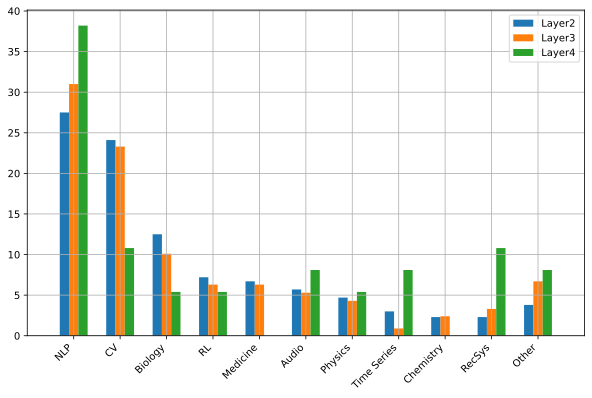

In [14]:
fig = plt.figure(figsize=(10, 6))
dr_names = ['NLP', 'CV', 'Biology', 'RL', 'Medicine', 'Audio', 'Physics', 'Time Series', 'Chemistry', 'RecSys', 'Other']
b1 = plt.bar([0.8+i for i in range(0, len(dr_names))], [dr_results[v][0] for v in dr_names], width=0.2)
b2 = plt.bar([1+i for i in range(0, len(dr_names))], [dr_results[v][1] for v in dr_names], width=0.2)
b3 = plt.bar([1.2+i for i in range(0, len(dr_names))], [dr_results[v][2] for v in dr_names], width=0.2)
# plt.bar([1, 2, 3, 4], [4, 5, 6, 7], bottom=[4, 5, 6, 7], width=0.3)
 
plt.xlim(0, 12)
plt.xticks(list(range(1, len(dr_names) + 1)), dr_names, rotation=45, horizontalalignment='right')
plt.grid(True)
 
plt.legend((b1, b2, b3), ('Layer2', 'Layer3', 'Layer4'))
plt.savefig('figures/dr_categories.pdf', bbox_inches='tight') 
plt.show()

In [15]:
from collections import defaultdict

direct = all_df[all_df['layer'] > 2].groupby(['dependency'])['name'].apply(set)

def get_degree(pkg: str, direct):
    res = direct[pkg]
    flag = set([pkg])
    next_layer = direct[pkg].intersection(set(direct.index)) - flag
    while next_layer:
        tmp = set()
        for d in next_layer:
            res = res.union(direct[d])
            flag.add(d)
            tmp = tmp.union(direct[d])
        next_layer = tmp.intersection(set(direct.index)) - flag
    return res

In [16]:
degree = {}
for pkg in direct.index:
    d1 = len(direct[pkg])
    d2 = len(get_degree(pkg, direct))
    degree[pkg] = [d1, d2, d2/d1]

degree = sorted(degree.items(), key=lambda x: x[1][1], reverse=True)
degree

[('torchvision', [990, 1272, 1.284848484848485]),
 ('tensorboard-data-server', [13, 846, 65.07692307692308]),
 ('tensorboard', [395, 830, 2.1012658227848102]),
 ('Keras', [197, 359, 1.8223350253807107]),
 ('pytorch-lightning', [229, 275, 1.2008733624454149]),
 ('torchmetrics', [51, 275, 5.392156862745098]),
 ('tensorflow-probability', [155, 227, 1.4645161290322581]),
 ('streamlit', [206, 221, 1.0728155339805825]),
 ('torchtext', [80, 200, 2.5]),
 ('tensorflow-addons', [118, 189, 1.6016949152542372]),
 ('tensorflow-hub', [106, 187, 1.7641509433962264]),
 ('tensorflow-estimator', [145, 177, 1.2206896551724138]),
 ('tensorflow-metadata', [15, 162, 10.8]),
 ('tensorflow-datasets', [64, 142, 2.21875]),
 ('pytorch-transformers', [35, 129, 3.6857142857142855]),
 ('pytorch-pretrained-bert', [32, 127, 3.96875]),
 ('seqeval', [70, 120, 1.7142857142857142]),
 ('fastai', [88, 95, 1.0795454545454546]),
 ('torchaudio', [81, 90, 1.1111111111111112]),
 ('tensorflow-serving-api', [19, 84, 4.42105263157

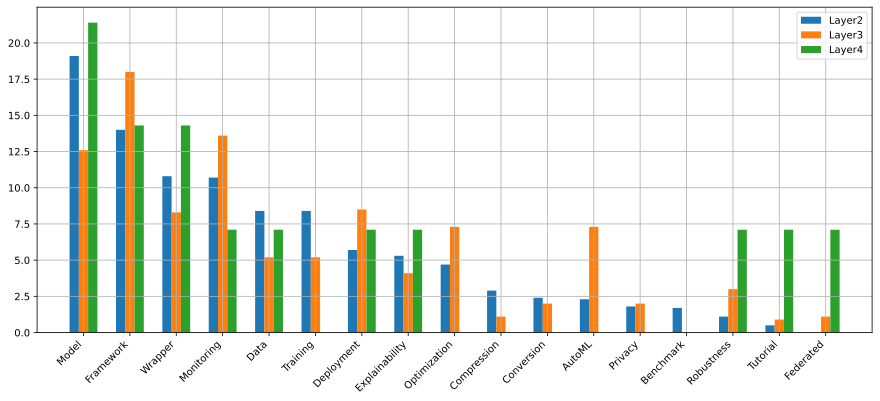

In [17]:
fig = plt.figure(figsize=(15, 6))
ndr_names = ['Model', 'Framework', 'Wrapper', 'Monitoring', 'Data', 'Training', 'Deployment', 'Explainability', 'Optimization', 
             'Compression', 'Conversion', 'AutoML', 'Privacy', 'Benchmark', 'Robustness', 'Tutorial', 'Federated']
b1 = plt.bar([0.8+i for i in range(0, len(ndr_names))], [ndr_results[v][0] for v in ndr_names], width=0.2)
b2 = plt.bar([1+i for i in range(0, len(ndr_names))], [ndr_results[v][1] for v in ndr_names], width=0.2)
b3 = plt.bar([1.2+i for i in range(0, len(ndr_names))], [ndr_results[v][2] for v in ndr_names], width=0.2)
# plt.bar([1, 2, 3, 4], [4, 5, 6, 7], bottom=[4, 5, 6, 7], width=0.3)
 
plt.xlim(0, 18)
plt.xticks(list(range(1, len(ndr_names) + 1)), ndr_names, rotation=45, horizontalalignment='right')
plt.grid(True)
 
plt.legend((b1, b2, b3), ('Layer2', 'Layer3', 'Layer4'))
plt.savefig('figures/ndr_categories.pdf', bbox_inches='tight') 
plt.show()

In [18]:
torch_dr = labelled_packages[(labelled_packages.framework == 'pytorch')].groupby(['DR/NDR', 'layer']).size().unstack().fillna(0).astype(int) \
.rename(columns={2: 'Layer 2', 3: 'Layer 3', 4: 'Layer 4', 5: 'Layer 5', 6: 'Layer 6'}, 
        index={'DR': 'PyTorch DR', 'NDR': "PyTorch NDR", '\\': 'PyTorch None'})
torch_dr_ratio = torch_dr / torch_dr.sum(axis=0)
tf_dr = labelled_packages[(labelled_packages.framework == 'tensorflow')].groupby(['DR/NDR', 'layer']).size().unstack().fillna(0).astype(int) \
.rename(columns={2: 'Layer 2', 3: 'Layer 3', 4: 'Layer 4', 5: 'Layer 5', 6: 'Layer 6'}, 
        index={'DR': 'TensorFlow DR', 'NDR': "TensorFlow NDR", '\\': 'TensorFlow None'})
tf_dr_ratio = tf_dr / tf_dr.sum(axis=0)
pp_dr = labelled_packages[(labelled_packages.framework == 'paddlepaddle')].groupby(['DR/NDR', 'layer']).size().unstack().fillna(0).astype(int) \
.rename(columns={2: 'Layer 2', 3: 'Layer 3', 4: 'Layer 4', 5: 'Layer 5', 6: 'Layer 6'}, 
        index={'DR': 'PaddlePaddle DR', 'NDR': "PaddlePaddle NDR", '\\': 'PaddlePaddle None'})
pp_dr_ratio = pp_dr / pp_dr.sum(axis=0)
pd.concat([torch_dr_ratio, tf_dr_ratio, pp_dr_ratio], axis=0)

layer,Layer 2,Layer 3,Layer 4,Layer 5,Layer 6
DR/NDR,,,,,
PyTorch DR,0.571429,0.636842,0.583333,1.000000,1.000000
PyTorch NDR,0.320557,0.236842,0.166667,0.000000,0.000000
PyTorch None,0.108014,0.126316,0.250000,0.000000,0.000000
TensorFlow DR,0.551282,0.540881,0.652174,0.857143,0.333333
TensorFlow NDR,0.320513,0.320755,0.260870,0.071429,0.333333
TensorFlow None,0.128205,0.138365,0.086957,0.071429,0.333333
PaddlePaddle DR,0.422535,0.100000,0.500000,NaN,NaN
PaddlePaddle NDR,0.323944,0.250000,0.000000,NaN,NaN
PaddlePaddle None,0.253521,0.650000,0.500000,NaN,NaN


In [19]:
torch_dr_cat = labelled_packages[(labelled_packages.framework == 'pytorch') & (labelled_packages['DR/NDR'] == 'DR')] \
.groupby(['Category', 'layer']).size().unstack().fillna(0).astype(int)
torch_ndr_cat = labelled_packages[(labelled_packages.framework == 'pytorch') & (labelled_packages['DR/NDR'] == 'NDR')] \
.groupby(['Category', 'layer']).size().unstack().fillna(0).astype(int)
torch_dr_cat, torch_ndr_cat

(layer         2   3  4  5  6
 Category                    
 Audio        10   7  0  0  0
 Biology      20  13  0  0  0
 CV           38  34  1  1  1
 Chemistry     4   2  0  0  0
 Medicine     10  10  0  0  0
 NLP          48  33  3  0  0
 Other         7   7  1  0  1
 Physics       6   5  1  0  0
 RL           12   5  0  0  0
 RecSys        3   4  1  0  0
 Time Series   6   1  0  1  0,
 layer            2   3  4
 Category                 
 AutoML           1   1  0
 Benchmark        2   0  0
 Compression      3   1  0
 Conversion       1   1  0
 Data            10   2  0
 Deployment       0   2  0
 Explainability   3   1  1
 Federated        0   1  0
 Framework       15  11  0
 Model           19   7  1
 Monitoring       9   3  0
 Optimization     6   2  0
 Privacy          1   1  0
 Robustness       2   2  0
 Training         9   3  0
 Tutorial         1   0  0
 Wrapper         10   7  0)

In [20]:
tf_dr_cat = labelled_packages[(labelled_packages.framework == 'tensorflow') & (labelled_packages['DR/NDR'] == 'DR')] \
.groupby(['Category', 'layer']).size().unstack().fillna(0).astype(int)
tf_ndr_cat = labelled_packages[(labelled_packages.framework == 'tensorflow') & (labelled_packages['DR/NDR'] == 'NDR')] \
.groupby(['Category', 'layer']).size().unstack().fillna(0).astype(int)
tf_dr_cat, tf_ndr_cat

(layer         2   3   4  5  6
 Category                     
 Audio         7   4   3  0  0
 Biology      17   8   2  2  0
 CV           32  14   3  2  0
 Chemistry     3   3   0  0  0
 Medicine     10   3   0  2  2
 NLP          32  31  11  3  1
 Other         4   7   2  2  1
 Physics       8   4   1  1  0
 RL            9   8   2  0  0
 RecSys        4   3   3  0  0
 Time Series   3   1   3  0  0,
 layer            2   3  4  5  6
 Category                       
 AutoML           3   6  0  0  0
 Benchmark        1   0  0  0  0
 Compression      2   0  0  0  0
 Conversion       3   1  0  0  0
 Data             4   3  1  0  1
 Deployment       9   6  1  1  1
 Explainability   6   3  0  0  0
 Federated        0   0  1  0  0
 Framework        8   6  2  0  0
 Model           13   5  2  0  0
 Monitoring       9  10  1  0  0
 Optimization     2   5  0  0  0
 Privacy          2   1  0  0  0
 Robustness       0   1  1  0  0
 Training         5   2  0  0  2
 Tutorial         0   1  1  0  0
 W

In [21]:
pp_dr_cat = labelled_packages[(labelled_packages.framework == 'paddlepaddle') & (labelled_packages['DR/NDR'] == 'DR')] \
.groupby(['Category', 'layer']).size().unstack().fillna(0).astype(int)
pp_ndr_cat = labelled_packages[(labelled_packages.framework == 'paddlepaddle') & (labelled_packages['DR/NDR'] == 'NDR')] \
.groupby(['Category', 'layer']).size().unstack().fillna(0).astype(int)
pp_dr_cat, pp_ndr_cat

(layer      2  3  4
 Category          
 Audio      1  0  0
 CV        12  2  0
 NLP       10  0  1
 Other      3  0  0
 RL         3  0  0
 RecSys     1  0  0,
 layer       2  3
 Category        
 Conversion  2  0
 Data        2  0
 Deployment  6  2
 Framework   5  2
 Model       1  1
 Privacy     1  0
 Training    3  0
 Wrapper     3  0)